# GAN for Sequential data

## Imports

In [1]:
import torch
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "6"

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from viz import updatable_display2

import torch.nn as nn
import torch.nn.functional as F
from torch import nn, optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

from utils import onehot,num_parameters,sample_noise,true_target,fake_target
from layers import GumbelSoftmax
from generators import GumbelRelRNNGenerator
from discriminators import GumbelRelRNNDiscriminator

from timeSeries import Sinusoids
from visualize import plotSamples

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_save_path = os.path.join("Saved_models","RelGAN")

print(device)

cuda


## Dataset loading

In [2]:
num_steps = 12
dataset_size = 10000
batch_size = 32
num_classes = 10

data_loader = DataLoader(Sinusoids(num_steps,virtual_size=dataset_size,quantization=num_classes),
                         batch_size=batch_size,shuffle=True,num_workers=4,drop_last=True)
valid_data_loader = DataLoader(Sinusoids(num_steps,virtual_size=dataset_size,quantization=num_classes),
                               batch_size=batch_size,shuffle=True,num_workers=4,drop_last=True)

## Training setup

In [3]:
lr = 1e-4

vocab_size = num_classes+1
pad_id = num_classes
noise_size = 128
num_embeddings = 6

num_test_samples = 100
test_noise = sample_noise(num_test_samples,noise_size,device)

# intialize models
generator = GumbelRelRNNGenerator(mem_slots=8,head_size=16,num_heads=8,noise_size=noise_size,output_size=vocab_size,
                               device=device).to(device)
discriminator = GumbelRelRNNDiscriminator(input_size=vocab_size,hidden_size=128,output_size=1,
                                          num_embeddings=num_embeddings).to(device)

# otpimizers
g_optimizer = optim.Adam(generator.parameters(),lr=lr)
d_optimizer = optim.Adam(discriminator.parameters(),lr=lr)
g_lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(g_optimizer,mode="min",factor=0.5,patience=2,verbose=True)

# losses
loss_fun = nn.BCEWithLogitsLoss()
loss_weight = torch.ones(vocab_size).to(device)
loss_weight[pad_id] = 0.0
pretrain_loss_fun = nn.NLLLoss(weight=loss_weight)

# Create logger instance
dis = updatable_display2(['train'],["epoch","d_error","g_error","beta"])
pretrain_dis = updatable_display2(['train'],["pretrain epoch","pretrain_g_error"])

print(generator)
print()
print(discriminator)
np_g = num_parameters(generator)
np_d = num_parameters(discriminator)
print("Number of parameters for G: {}\nNumber of parameters for D: {}\nNumber of parameters in total: {}"
      .format(np_g,np_d,np_g+np_d))

GumbelRelRNNGenerator(
  (input_dropout): Dropout(p=0.2)
  (z2m): Linear(in_features=128, out_features=128, bias=True)
  (batchnorm1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (embedding): Embedding(11, 128)
  (batchnorm2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relRNN): RelationalRNNCell(memory_size = [?,8,128])
  (m2o): Linear(in_features=1024, out_features=11, bias=True)
  (activation): LeakyReLU(negative_slope=0.2)
  (last_activation): GumbelSoftmax()
)

GumbelRelRNNDiscriminator(
  (embeddings): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=11, out_features=128, bias=True)
      (1): LeakyReLU(negative_slope=0.2)
    )
    (1): Sequential(
      (0): Linear(in_features=11, out_features=128, bias=True)
      (1): LeakyReLU(negative_slope=0.2)
    )
    (2): Sequential(
      (0): Linear(in_features=11, out_features=128, bias=True)
      (1): LeakyReLU(negative_slope=0.2)
    )
  

### Pretrain Generator

In [4]:
def pretrain_generator(real_data,fake_data,optimizer):
    '''
    Pretrain the generator to generate realistic samples for a good initialization
    '''
    num_classes = fake_data.size(2)
    # Reset gradients
    optimizer.zero_grad()
    
    loss = 0
    fake_data = torch.log(fake_data)
    for i in range(fake_data.size(1)):
        loss += pretrain_loss_fun(fake_data[:,i,:],real_data[:,i])
    loss.backward()
    
    optimizer.step()
    return loss

### Train Generator

In [5]:
def train_generator(real_data_onehot,fake_data,optimizer):
    '''
    Train the generator to generate realistic samples and thereby fool the discriminator
    '''
    N = fake_data.size(0)
    
    # Reset gradients
    optimizer.zero_grad()
    
    # 1.1 Train on Real Data
    c_x_r = discriminator(real_data_onehot)

    # 1.2 Train on Fake Data
    c_x_f = discriminator(fake_data)
        
    # compute the average of c_x_*
    c_x_r_mean = torch.mean(c_x_r,dim=0)
    c_x_f_mean = torch.mean(c_x_f,dim=0)

    losses_real = []
    losses_fake = []
    for i in range(c_x_r.size(1)):
        losses_real.append(loss_fun(c_x_r[:,i,:]-c_x_f_mean[i,:],fake_target(N,device)))
        losses_fake.append(loss_fun(c_x_f[:,i,:]-c_x_r_mean[i,:],true_target(N,device)))
    loss_real = torch.stack(losses_real).mean()
    loss_fake = torch.stack(losses_fake).mean()
    
    loss = (loss_real + loss_fake)/2.0
    loss.backward()
    
    optimizer.step()
    return loss

### Train Discriminator

In [6]:
def train_discriminator(real_data_onehot,fake_data,optimizer):
    '''
    Train the discriminator to distinguish between real and fake data
    '''
    N = real_data_onehot.size(0)
    
    # Reset gradients
    optimizer.zero_grad()

    # 1.1 Train on Real Data
    c_x_r = discriminator(real_data_onehot)

    # 1.2 Train on Fake Data
    c_x_f = discriminator(fake_data)
        
    # compute the average of c_x_*
    c_x_r_mean = torch.mean(c_x_r,dim=0)
    c_x_f_mean = torch.mean(c_x_f,dim=0)
    
    losses_real = []
    losses_fake = []
    for i in range(c_x_r.size(1)):
        losses_real.append(loss_fun(c_x_r[:,i,:]-c_x_f_mean[i,:],true_target(N,device)))
        losses_fake.append(loss_fun(c_x_f[:,i,:]-c_x_r_mean[i,:],fake_target(N,device)))
    loss_real = torch.stack(losses_real).mean()
    loss_fake = torch.stack(losses_fake).mean()
    
    loss = (loss_real + loss_fake)/2.0
    loss.backward()
    
    # 1.3 Update weights with gradients
    optimizer.step()
    return loss

## Train the model

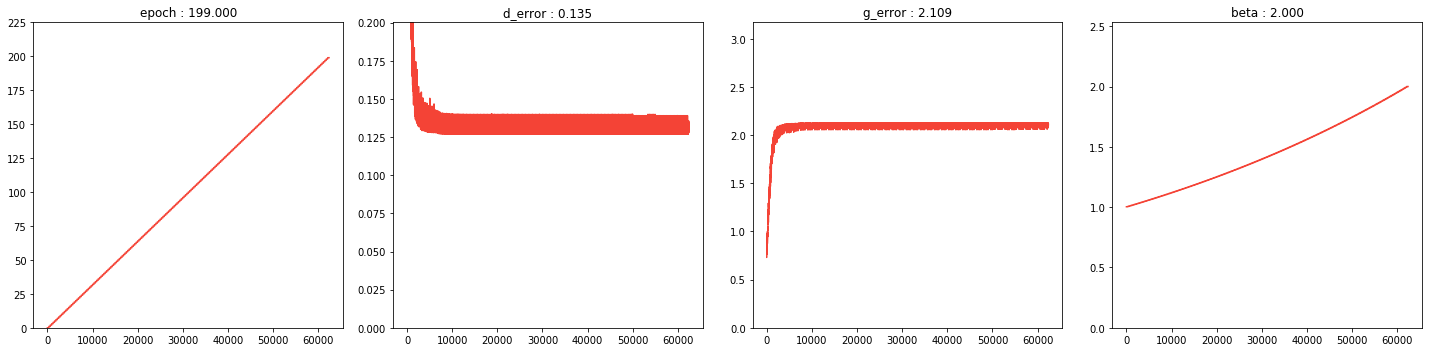

<Figure size 432x288 with 0 Axes>

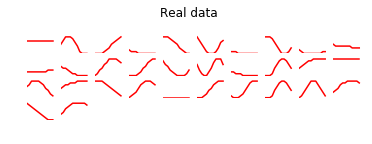

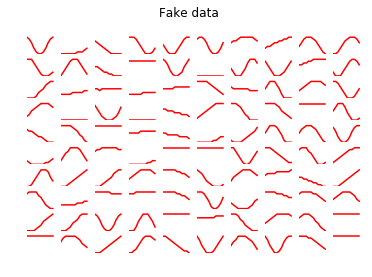

In [7]:
gen_steps = 1
gen_train_freq = 5
max_temperature = torch.FloatTensor([2]).to(device)
pretrain_temperature = torch.FloatTensor([1]).to(device)

epochs_pretrain = 100
pretrain_step = 0

num_epochs = 200
global_step = 0
epoch = 0
d_error = 0
g_error = 0

# pretrain generator
for ep in range(epochs_pretrain):
    batch_error = []
    for n_batch,real_batch in enumerate(data_loader):
        N = real_batch.size(0)
        real_batch = real_batch.squeeze(2)
        real_data = real_batch.to(device)
        real_data_onehot = onehot(real_batch,vocab_size).to(device)

        # Generate fake data
        generator.train()
        noise = sample_noise(N,noise_size,device)
        fake_data = generator(z=noise,num_steps=num_steps,temperature=pretrain_temperature,
                              x=real_data.long())
        # Train G
        pretrain_g_error = pretrain_generator(real_data,fake_data,g_optimizer)
        batch_error.append(pretrain_g_error)
        
        del fake_data
        del real_data
        
        # Log batch error and delete tensors
        pretrain_dis.update(pretrain_step,'train',{"pretrain epoch":ep,"pretrain_g_error":pretrain_g_error.item()})
        pretrain_step += 1
        if pretrain_step % 200 == 0:
            pretrain_dis.display(scale=True)
    g_lr_scheduler.step(torch.stack(batch_error).mean())
    if ep % 10 == 0:
        generator.eval()
        test_samples = generator(z=test_noise,num_steps=num_steps,temperature=pretrain_temperature)
        test_samples_vals = torch.argmax(test_samples,dim=2)
        plotSamples(test_samples_vals,xu=num_steps,yu=vocab_size,title="Fake data")
        plt.show()
        
# train adverserially
try:
    while epoch < num_epochs:
        batch_error = []
        temperature = max_temperature**((epoch+1)/num_epochs)
        for n_batch,real_batch in enumerate(data_loader):
            N = real_batch.size(0)
            # 1. Train Discriminator
            real_batch = real_batch.squeeze(2)
            real_data = real_batch.to(device)
            real_data_onehot = onehot(real_batch,vocab_size).to(device)
            real_data_onehot[real_data_onehot==1] = 0.9
            real_data_onehot[real_data_onehot==0] = (1.0-0.9)/(vocab_size-1.0)

            # Generate fake data and detach 
            # (so gradients are not calculated for generator)
            noise_tensor = sample_noise(N,noise_size,device)
            with torch.no_grad():
                fake_data = generator(z=noise_tensor,num_steps=num_steps,
                                             temperature=temperature).detach()
            # Train D
            d_error = train_discriminator(real_data_onehot,fake_data,d_optimizer)
            del noise_tensor

            # 2. Train Generator every 'gen_train_freq' steps
            if global_step % gen_train_freq == 0:
                for _ in range(gen_steps):
                    # Generate fake data
                    fake_data = generator(z=sample_noise(N,noise_size,device),num_steps=num_steps,
                                                 temperature=temperature)
                    # Train G
                    g_error = train_generator(real_data_onehot,fake_data,g_optimizer)

            # Log batch error and delete tensors
            dis.update(global_step,'train',{"epoch":epoch,"d_error":d_error.item(),"g_error":g_error.item(),
                                            "beta":temperature.item()})
            batch_error.append(g_error)
            global_step += 1
            del fake_data
            del real_data_onehot

            # Display Progress every few batches
            if global_step % 50 == 0:
                test_samples = generator(z=test_noise,num_steps=num_steps,temperature=temperature)
                test_samples_vals = torch.argmax(test_samples,dim=2)
                dis.display(scale=True)
                plotSamples(real_data,xu=num_steps,yu=num_classes,title="Real data")
                plotSamples(test_samples_vals,xu=num_steps,yu=num_classes,title="Fake data")
                if epoch % 50 == 0:
                    plt.savefig("Figures/RaS-Rel-RNN-ToyData-Epoch="+str(epoch)+".png")
                plt.show()
                del test_samples
                del test_samples_vals
            del real_data
            del real_batch
        g_lr_scheduler.step(torch.stack(batch_error).mean())
        epoch += 1
except:
    test_samples = generator(z=test_noise,num_steps=num_steps,temperature=temperature)
    test_samples_vals = torch.argmax(test_samples,dim=2)
    dis.display(scale=True)
    plotSamples(test_samples_vals,xu=num_steps,yu=num_classes,title="Fake data")
    plt.savefig("Figures/RaS-Rel-RNN-ToyData.png")
    plt.show()
    del test_samples
    del test_samples_vals

del g_lr_scheduler
g_optimizer.zero_grad()
d_optimizer.zero_grad()
del g_optimizer
del d_optimizer
del dis
del pretrain_dis
torch.cuda.empty_cache()

## Save model

In [11]:
#torch.save(generator.state_dict(),os.path.join(model_save_path,generator.__class__.__name__))
#torch.save(discriminator.state_dict(),os.path.join(model_save_path,discriminator.__class__.__name__))

# to load model run
# model.load_state_dict(torch.load(PATH))

torch.cuda.empty_cache()

### Eval generator function

In [9]:
def nll_gen(real_data,fake_data):
    '''
    Evaluate the generators ability to generate diverse samples
    '''    
    loss = 0
    fake_data = torch.log(fake_data)
    for i in range(fake_data.size(1)):
        loss += pretrain_loss_fun(fake_data[:,i,:],real_data[:,i])
    return loss/fake_data.size(1)

## Evaluate generator

In [10]:
torch.cuda.empty_cache()

# evaluate generator
nll_gen_error = []
for n_batch,real_batch in enumerate(valid_data_loader):
    N = real_batch.size(0)
    real_batch = real_batch.squeeze(2)
    real_data = real_batch.to(device)

    # Generate fake data
    noise = sample_noise(N,noise_size,device).detach()
    fake_data = generator(z=noise,num_steps=num_steps,temperature=max_temperature,
                          x=real_data.long()).detach()
    # Train G
    nll_gen_error.append(nll_gen(real_data,fake_data))

    del fake_data
    del real_batch
    del real_data
    del noise
    torch.cuda.empty_cache()
nll_gen_error = torch.stack(nll_gen_error)
print(nll_gen_error.mean())

tensor(1.4176, device='cuda:0')
